# Sequence+

**Goal**: Build a model that can predict any given sequence of pitches run value<br>
**Author**: Jensen Holm <br>
**Date**: October / November 2024

In [1]:
%pip install git+https://github.com/Jensen-holm/statcast-era-pitches.git

  Cloning https://github.com/Jensen-holm/statcast-era-pitches.git to /tmp/pip-req-build-fvlh30kq
  Running command git clone --filter=blob:none --quiet https://github.com/Jensen-holm/statcast-era-pitches.git /tmp/pip-req-build-fvlh30kq
  Resolved https://github.com/Jensen-holm/statcast-era-pitches.git to commit 6ff4dcb3e47835ef8efbfd8fcddbe490d54fd7ae
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for statcast_pitches: filename=statcast_pitches-0.1.0-py3-none-any.whl size=4163 sha256=e4eca4c24139463829248f3b5b68c75d85e1f24cab0bb4ba547aee01f55c19c1
  Stored in directory: /tmp/pip-ephem-wheel-cache-lz6gxcx0/wheels/e9/57/38/e71dc59ee43755ab4528e7e5817aee273ca7897f4f4a083106
Successfully built statcast_pitches


In [2]:
import statcast_pitches
import polars as pl
import numpy as np
from plotnine import *
import plotly.express as px

## Loading Data

Using all pitches thrown in the statcast-era (2015-present) as our data for this model. <br>
I will also be using `../data/run_values.csv` for calculating run values of each pitch, this data represents 2024 only.

**Data Dictionary**: [link](https://baseballsavant.mlb.com/csv-docs) <br>
**statcast_pitches package info**: [link](https://github.com/Jensen-holm/statcast-era-pitches)

In [3]:
# use statcast pitches to get all pitches thrown in since hawkeye began
pitches_lf: pl.LazyFrame = (statcast_pitches.load()
                            .filter(pl.col("game_date").dt.year() >= 2024))

latest_date = pitches_lf.select("game_date").max().collect().item().date()
earliest_date = pitches_lf.select("game_date").min().collect().item().date()
n_pitches = pitches_lf.select(pl.len()).collect().item()

print(f"N Pitches: {n_pitches}")
print(f"Date Range: {earliest_date} - {latest_date}")

N Pitches: 761176
Date Range: 2024-03-15 - 2024-10-30


In [4]:
run_values_24 = pl.scan_csv(
    # os.path.join(DATA_DIR, "run_values.csv")
    "https://raw.githubusercontent.com/Jensen-holm/Sequence-Plus/refs/heads/main/data/run_values.csv"
).rename({"event": "events"}) # it is called 'events' in pitches_df

# Feature Engineering

adding the following features to `pitches_df`

| Feature Name | Description |
|------|-------------|
| **delta_run_exp** | run value associated with the pitch outcome from `run_values_24`|
| **x_0.120** | position in the x dimension of the pitch at decision time (~0.12s) |
| **y_0.120** | position in the y dimension of the pitch at decision time (~0.12s) |
| **z_0.120** | position in the z dimension of the pitch at decision time (~0.12s) |
| **x_0.167** | position in the x dimension of the pitch at commit time (~0.167s) |
| **y_0.167** | position in the y dimension of the pitch at commit time (~0.167s) |
| **z_0.167** | position in the z dimension of the pitch at commit time (~0.167s) |
| **velocity_diff** | difference in velocity between pitches in a two pitch sequence |
| **effective_velocity_diff** | difference in effective velocity between pitches in a two pitch sequence |
| **pfx_x_diff** | difference in horizontal movement between pitches in a two pitch sequence |
| **pfx_z_diff** | difference in vertical movement between pitches in a two pitch sequence |
| **3d_dist_0.167** | 3D euclidean distance between pitches in a two pitch sequence 0.167 seconds after release |
| **3d_dist_0.120** | 3D distance between pitches in a two pitch sequence at 0.120 seconds after release |
| **distance** | 2D euclidean distance between pitch locations when crossing the plate in a two pitch sequence |
| **seq_delta_run_exp** | sum of `delta_run_exp` in a two pitch sequence |
| **plate_x_diff** | difference in plate_x between pitches in a two pitch sequence |
| **plate_z_diff** | difference in plate_z between pitches in a two pitch sequence |

On top of adding these features, attributes from LHP should be mirrored as if they were thrown by a RHP for consistency

## Expected Run Value

Joining the expected runs from run_values_24 to the pitches dataframe so that each pitch has an associated run value.

**New Features**

- `delta_run_exp`

In [5]:

description_replace_mapping = {
    "Ball": "ball",
    "In play, run(s)": "hit_into_play",
    "In play, out(s)": "hit_into_play",
    "In play, no out": "hit_into_play",
    "Called Strike": "called_strike",
    "Foul": "foul",
    "Swinging Strike": "swinging_strike",
    "Blocked Ball": "ball",
    "Swinging Strike (Blocked)": "swinging_strike",
    "Foul Tip": "swinging_strike",
    "Foul Bunt": "foul",
    "Hit By Pitch": "hit_by_pitch",
    "Pitchout": "ball",
    "Missed Bunt": "swinging_strike",
    "Bunt Foul Tip": "swinging_strike",
    "Foul Pitchout": "foul",
    "Ball In Dirt": "ball",
}

def add_pitch_run_value(lf: pl.LazyFrame) -> pl.LazyFrame:
    """Takes in a dataframe of pitches, and adds 2024 run value to each one"""
    pitch_runs_lf = lf.join(
        other=run_values_24,
        on=["events", "balls", "strikes"],
        how="left",
    )

    mapped_des_pitches = pitch_runs_lf.with_columns([
        pl.col("description")
        .replace_strict(description_replace_mapping, default=None)
        .alias("play_des"),
    ])

    pitches_run_value_lf = mapped_des_pitches.join(
        other=run_values_24,
        right_on=["events", "balls", "strikes"],
        left_on=["play_des", "balls", "strikes"],
        how="left",
        suffix="_des",
    ).with_columns([
        pl.when(pl.col("delta_run_exp").is_null())
        .then(pl.col("delta_run_exp_des"))
        .otherwise(pl.col("delta_run_exp"))
        .alias("delta_run_exp"),
    ])
    return pitches_run_value_lf

pitches_run_value_lf = pitches_lf.pipe(add_pitch_run_value)
pitches_run_value_lf.select(
    "pitch_type",
    "description",
    "balls",
    "strikes",
    "delta_run_exp",
).describe()

statistic,pitch_type,description,balls,strikes,delta_run_exp
str,str,str,f64,f64,f64
"""count""","""747483""","""761176""",761176.0,761176.0,725703.0
"""null_count""","""13693""","""0""",0.0,0.0,35473.0
"""mean""",null,null,0.867148,0.901089,0.000023
"""std""",null,null,0.965891,0.829563,0.239968
"""min""","""CH""","""ball""",0.0,0.0,-1.463
"""25%""",null,null,0.0,0.0,-0.067
"""50%""",null,null,1.0,1.0,-0.016
"""75%""",null,null,1.0,2.0,0.035
"""max""","""SV""","""swinging_strike_blocked""",4.0,2.0,3.525


In order to keep it simple, I am mirroring the movement and the horizontal release position of each pitch thrown from LHP, to as if it were thrown by RHP.

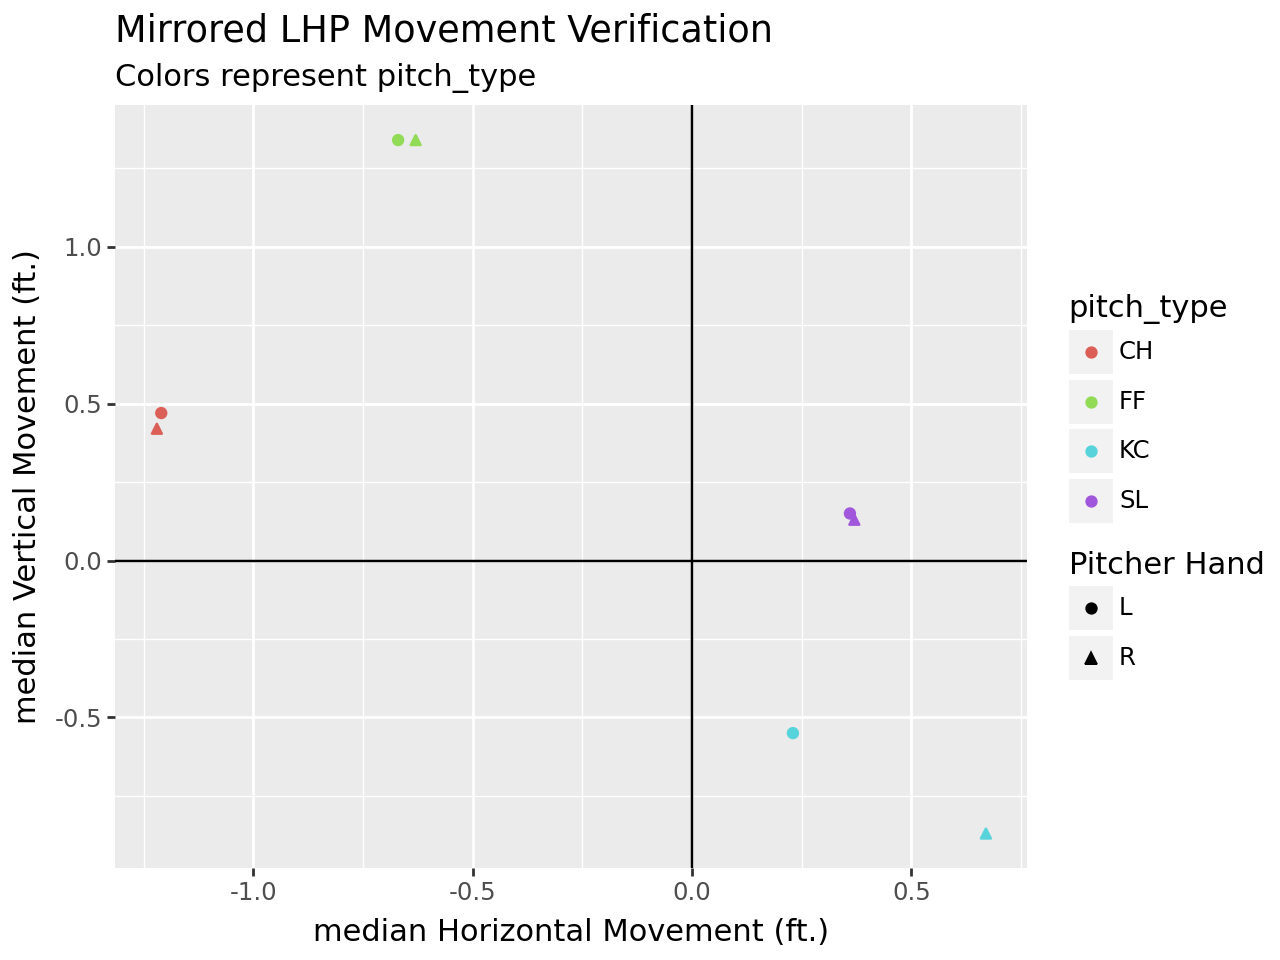

In [6]:
def mirror_lhp_to_rhp(lf: pl.LazyFrame) -> pl.LazyFrame:
    return lf.with_columns(
        # mirror LHP horizontal movement
        pl.when(pl.col("p_throws") == "L")
        .then(-pl.col("pfx_x"))
        .otherwise(pl.col("pfx_x")),

        # also mirror the horizontal release point
        # (release_pos_x is from catcher perspective)
        pl.when(pl.col("p_throws") == "L")
        .then(-pl.col("release_pos_x"))
        .otherwise(pl.col("release_pos_x")),
    )

mirrored_pitches_lf = pitches_run_value_lf.pipe(mirror_lhp_to_rhp)

# for verification
movement_plt = (
    ggplot(
        mirrored_pitches_lf
        .filter(pl.col("pitch_type").is_in(["FF", "KC", "SL", "CH"]))
        .group_by("pitch_type", "p_throws")
        .agg(
            pl.col("pfx_x").median().alias("median_pfx_x"),
            pl.col("pfx_z").median().alias("median_pfx_z"),
        ).collect(),
        aes(x="median_pfx_x", y="median_pfx_z", color="pitch_type", shape="p_throws"))
    + geom_point()
    + geom_vline(xintercept=0)
    + geom_hline(yintercept=0)
    + labs(
        title="Mirrored LHP Movement Verification",
        x="median Horizontal Movement (ft.)",
        y="median Vertical Movement (ft.)",
        shape="Pitcher Hand",
        subtitle="Colors represent pitch_type",
    )
)

movement_plt.show()

Horizontal movement profiles are mirrored now!

## 3D Pitch Location Estimation

Now to add ball positions in 3D space at both [decision time]() (0.12s) & [commit time]() (0.167s)

### Step 1: Time to 50ft. from home plate

Estimate the time it took the baseball to travel from release point to 50ft from home plate (the point where we have measurements for a &v in x, y, z dimensions)

$t_{50} = \frac{(60 + 6/12) - 50 - extension}{vft * 1.05}$

Where ...
- $extension = $ distance from the rubber where the pitch was released<br>
- $vft = $ release_speed in ft/s

I multiply the velocity by 1.05 in order to dialate the time by 5%. This makes our estimation of position more accurate because it helps account for error that we get from assuming that acceleration is constant in the kinematic equations for displacement.

**New Features**
- `t50`: estimated time it took the ball to get to 50ft. from home plate
- `release_pos_y`: release position in the y dimension converted to feet


In [7]:
def displacement(p0, v0, t, a):
    return p0 + v0 * t + 0.5 * a * t**2

def convert_release_y_to_ft(lf: pl.LazyFrame) -> pl.LazyFrame:
    return lf.with_columns(pl.col("release_pos_y") / 12)

def estimate_time_to_50ft(lf: pl.LazyFrame) -> pl.LazyFrame:
    return lf.with_columns(
        ((((60 + 6/12) - 50) - pl.col("release_extension"))
        / ((pl.col("release_speed") * (5280/3600) * 1.05))).alias("t50")
    )

time_to_50ft_lf = (mirrored_pitches_lf
                   .pipe(convert_release_y_to_ft)
                   .pipe(estimate_time_to_50ft))

(time_to_50ft_lf
    .select("release_pos_y", "t50")
    .describe())

statistic,release_pos_y,t50
str,f64,f64
"""count""",746281.0,745450.0
"""null_count""",14895.0,15726.0
"""mean""",4.50379,0.029637
"""std""",0.038004,0.004399
"""min""",4.313333,0.012265
"""25%""",4.48,0.026799
"""50%""",4.5025,0.029316
"""75%""",4.528333,0.032118
"""max""",4.775833,0.136384


### Step 2: x, y, & z positions at 50ft. from home plate

For this I use the kinematic equations with the acceleration, velocity and now our time estimate, $t_{50}$, to calculate displacement in each dimension.

$d_{50} = r_{dim} + v_{dim} * t_{50} * \frac{1}{2} * a_{dim} * t_{50}^2$

Where ...
- $r_{dim} = $ release position in x, y or z dimension
- $v_{dim} = $ velocity at 50ft. from home plate in x, y or z dimension
- $a_{dim} = $ acceleration at 50ft. from home plate in x, y or z dimension
- $t_{50} = $ estimated time that it took to get to 50ft. from home plate from step 1

**New Features**
- `x50`: position in the x dimension when the ball is 50ft. from home plate
- `y50`: position in the y dimension when the ball is 50ft. from home plate
- `z50`: position in the z dimension when the ball is 50ft. from home plate


In [8]:
def estimate_pos_at_50ft(lf: pl.LazyFrame) -> pl.LazyFrame:
    return lf.with_columns(
        displacement(
            p0=pl.col(f"release_pos_{d}"),
            v0=pl.col(f"v{d}0"),
            a=pl.col(f"a{d}"),
            t=pl.col("t50"),
        ).alias(f"{d}50")
        for d in ["x", "y", "z"]
    )

pos_at_50ft_lf = time_to_50ft_lf.pipe(estimate_pos_at_50ft)

(pos_at_50ft_lf
    .select("x50", "y50", "z50")
    .describe())

statistic,x50,y50,z50
str,f64,f64,f64
"""count""",745450.0,745450.0,745450.0
"""null_count""",15726.0,15726.0,15726.0
"""mean""",-1.841894,0.69484,5.641312
"""std""",0.750444,0.391589,0.491664
"""min""",-5.027341,-1.990811,1.036836
"""25%""",-2.304915,0.469149,5.381889
"""50%""",-1.799675,0.72818,5.67098
"""75%""",-1.314786,0.915064,5.945786
"""max""",1.349322,2.622332,9.137442


### Step 3: Estimate 3D positions at commit time & decision time

Now we can make an estimate of where the ball is in all dimensions, at any given time. But I am interested specifically in 0.120 seconds after release (commit time), and 0.167 seconds after release (decision time).

For this I use the same formula that I used to esimate position at 50ft. from home plate, except I start from that 50ft. mark by calculating the difference in time between $t_{50}$ and $t_{i}$.

$d_{i} = p_{50} + v_{50} * (t_{50} - t_{i}) * \frac{1}{2} * a_{50} * (t_{50} - t_{i})^2$

Where ...
- $p_{50} = $ position in x, y, or z dimension at 50 ft. from home plate

I am assuming that both $v$ and $a$ are constant, again using a 5% time dilation as a crutch to help account for this.

**New Features**
- `x_0.120`: position in the x dimension at 0.120 seconds after release (commit time)
- `y_0.120`: position in the y dimension at 0.120 seconds after release (commit time)
- `y_0.120`: position in the z dimension at 0.120 seconds after release (commit time)
- `x_0.167`: position in the x dimension at 0.120 seconds after release (decision time)
- `y_0.167`: position in the y dimension at 0.120 seconds after release (decision time)
- `y_0.167`: position in the z dimension at 0.120 seconds after release (decision time)
- `t_plate`: estimated time that it takes the ball to reach home plate
- `x_plate`: position in the x dimension when the ball crossed the plate
- `y_plate`: position in the y dimension when the ball crossed the plate
- `z_plate`: position in the z dimension when the ball crossed the plate


In [9]:
def estimate_time_to_plate(lf: pl.LazyFrame) -> pl.LazyFrame:
    return lf.with_columns(
        (((60 + 6/12) - pl.col("release_extension"))
        / ((pl.col("release_speed") * (5280/3600) * 1.05))).alias("t_plate")
    )

def estimate_ball_pos_at_plate(lf: pl.LazyFrame) -> pl.LazyFrame:
    return lf.with_columns(
        displacement(
            p0=pl.col(f"{d}50"),
            v0=pl.col(f"v{d}0"),
            a=pl.col(f"a{d}"),
            t=pl.col("t_plate") - pl.col("t50"),
        ).alias(f"{d}_plate")
        for d in ["x", "y", "z"]
    )

def estimate_ball_pos_at_t(lf: pl.LazyFrame, times: list[float]) -> pl.LazyFrame:
    return lf.with_columns(
        displacement(
            p0=pl.col(f"{d}50"),
            v0=pl.col(f"v{d}0"),
            a=pl.col(f"a{d}"),
            t=t - pl.col("t50"),
        ).alias(f"{d}_{t:.3f}")
        for d in ["x", "y", "z"]
        for t in times
    )

TIMES = [0.120, 0.167]

ball_pos_lf = (pos_at_50ft_lf
               .pipe(estimate_time_to_plate)
               .pipe(estimate_ball_pos_at_plate)
               .pipe(estimate_ball_pos_at_t, TIMES))

(ball_pos_lf
    .select("t50", "x_0.120", "y_0.120", "z_0.120",
            "x_0.167", "y_0.167", "z_0.167", "x_plate", "y_plate", "z_plate")
    .describe())

statistic,t50,x_0.120,y_0.120,z_0.120,x_0.167,y_0.167,z_0.167,x_plate,y_plate,z_plate
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""",745450.0,745450.0,745450.0,745450.0,745450.0,745450.0,745450.0,745450.0,745450.0,745450.0
"""null_count""",15726.0,15726.0,15726.0,15726.0,15726.0,15726.0,15726.0,15726.0,15726.0,15726.0
"""mean""",0.029637,-1.627299,-10.936196,5.204777,-1.523965,-16.886659,4.901972,-1.080414,-44.741142,2.635362
"""std""",0.004399,0.983568,1.025537,0.472491,1.155276,1.411775,0.507478,2.051601,0.437697,0.885576
"""min""",0.012265,-6.60534,-13.681389,1.381013,-7.414727,-20.63631,1.431101,-11.012415,-57.228537,-6.206166
"""25%""",0.026799,-2.063213,-11.759901,4.910474,-1.958383,-18.021553,4.570639,-1.797597,-45.020221,2.05403
"""50%""",0.029316,-1.420893,-11.088943,5.197198,-1.215323,-17.098705,4.883972,-0.393946,-44.734685,2.636855
"""75%""",0.032118,-0.953703,-10.206092,5.497094,-0.744161,-15.88191,5.215215,0.284999,-44.456599,3.219887
"""max""",0.136384,1.694922,-0.481725,8.93593,1.940703,-2.532972,9.571308,8.951553,-39.457035,12.055414


### Pitch Location Visualization

In order to make sure this is working, here I make a 3D scatter plot of 3 random pitches thrown by Yu Darvish in the 2024 season and their estimated positions at release, 50ft from home, commit time, decision time, and across the plate.

**Plot Line Color Legend**
- `Sweeper`: Purple
- `Splitter`: Yellow
- `Slider`: Green
- `Knuckle Curve`: Blue
- `Four Seam Fastball`: Red


In [10]:
pitch_types = ["KC", "FF", "FS", "SL", "ST"]
cols = ["pitch_type", "release_pos_x", "release_pos_y", "release_pos_z",
        "x50", "y50", "z50", "x_0.120", "y_0.120", "z_0.120",
        "x_0.167", "y_0.167", "z_0.167", "x_plate", "y_plate", "z_plate"]

extra_times = np.arange(0, 0.5, 0.05).tolist()
extra_time_cols = [f"{d}_{t:.3f}"
                   for d in ["x", "y", "z"]
                   for t in extra_times]

# for the visualization, I am going to use a lot more time intervals
# for position estimation to get a smoother curve
sample_pitch_df = (ball_pos_lf
                   .filter(pl.col("game_date").dt.year() == 2024)
                   .filter(pl.col("pitch_type").is_in(pitch_types))
                   .filter(pl.col("player_name") == "Darvish, Yu")
                   .pipe(estimate_ball_pos_at_t, extra_times)
                   .drop_nulls(cols + extra_time_cols)
                   .group_by("pitch_type")
                   .agg(pl.col("*").sample(1, seed=40))
                   .select(cols + extra_time_cols)
                   .explode([pl.col(col)
                             for col in (cols + extra_time_cols)
                             if col != "pitch_type"])
                   .collect())


fig = px.scatter_3d()
colors = {"KC": "blue", "FF": "red", "FS": "yellow", "SL": "green", "ST": "purple"}
for pitch in sample_pitch_df.iter_rows(named=True):
    pitch_fig = px.line_3d(
        x=[pitch["release_pos_x"]] + [pitch[f"x_{t:.3f}"] for t in extra_times],
        y=[pitch["release_pos_y"]] + [pitch[f"y_{t:.3f}"] for t in extra_times],
        z=[pitch["release_pos_z"]] + [pitch[f"z_{t:.3f}"] for t in extra_times],
    )

    pitch_fig.update_traces(line=dict(color=colors[pitch["pitch_type"]]))
    fig.add_traces(pitch_fig.data)

fig.update_layout(title=dict(text="Random Yu Darvish Pitch Location Estimation"), showlegend=True)
fig.show()

## Location Estimation Error

Since I have the ground truth for release position, I can measure roughly how accurate the position estimation functions are by trying to estimate this release position in 3D space. I compute the mean euclidean distance between estimated release position and actual release position.

$3Deuclideandistance = \sqrt{(x_1 - x_2)^2 + (y_1 - y_2)^2 + (z_1 - z_2)^2}$

Looking at the results, depending on the pitch type, it is typically off by anywhere between .4 inches and .8 inches on average.

**New Features**
- `approx_release_pos_x`: approximated release position in the x dimension working back from 50ft.
- `approx_release_pos_y`: approximated release position in the y dimension working back from 50ft.
- `approx_release_pos_z`: approximated release position in the z dimension working back from 50ft.


In [11]:
def estimate_release_pos(lf: pl.LazyFrame) -> pl.LazyFrame:
    return lf.with_columns(
        displacement(
            p0=pl.col(f"{d}50"),
            v0=pl.col(f"v{d}0"),
            a=pl.col(f"a{d}"),
            t=-pl.col("t50"),
        ).alias(f"approx_release_pos_{d}")
        for d in ["x", "y", "z"]
    )

ball_pos_lf = ball_pos_lf.pipe(estimate_release_pos)


def euclidean_distance(*pts):
    return sum((pt[0] - pt[1]) ** 2 for pt in pts) ** 0.5


(ball_pos_lf
    .drop_nulls([col for col in ball_pos_lf.collect_schema().names() if "release" in col])
    .select("release_pos_x", "release_pos_y", "release_pos_z",
            "approx_release_pos_x", "approx_release_pos_y", "approx_release_pos_z",
            "pitch_type")
    .filter(pl.col("pitch_type").is_in(pitch_types))
    .group_by("pitch_type")
    .agg(
        (euclidean_distance(
            *[(pl.col(f"approx_release_pos_{d}"), pl.col(f"release_pos_{d}"))
            for d in ["x", "y", "z"]]
        ).mean() * 12).alias("mean_euclidean_error_in.")
    )
    .collect())

pitch_type,mean_euclidean_error_in.
str,f64
"""ST""",0.527257
"""SL""",0.458928
"""KC""",0.591464
"""FF""",0.323073
"""FS""",0.438919


## Sequence Features

**New Feautres**

Everything in the `prev_features` list will be added, I don't want to type all of that out.

**Note**

May or may not need this depending on what sort of model I end up building

In [35]:
# features that we are interested in with regards to two pitch sequences
prev_features = [
    "prev_pfx_x",
    "prev_pfx_z",
    "prev_x_0.120",
    "prev_y_0.120",
    "prev_z_0.120",
    "prev_x_0.167",
    "prev_y_0.167",
    "prev_z_0.167",
    "prev_release_pos_x",
    "prev_release_pos_y",
    "prev_release_pos_z",
    "prev_release_speed",
    "prev_effective_speed",
    "prev_release_spin_rate",
    "prev_delta_run_exp",
    "prev_x_plate",
    "prev_y_plate",
    "prev_z_plate",
    "prev_pitch_type",
]

def two_pitch_sequences(lf: pl.LazyFrame, seq_features: list[str]) -> pl.LazyFrame:
    # sort the data such that the pitches are in descending order
    sort_cols = ["pitcher", "game_date", "at_bat_number", "pitch_number"]
    sorted_lf = lf.sort(
        by=sort_cols,
        descending=[True] * len(sort_cols),
    )

    return (sorted_lf
        .with_columns([
            pl.col(feature)
            .shift(-1)
            .over(["pitcher", "at_bat_number"])
            .alias(f"prev_{feature}")
            for feature in [f.replace("prev_", "") for f in seq_features]
        ])
        .select(*sort_cols + seq_features)
        .join(other=lf, on=sort_cols, how="right")
    )

sequence_pitches_lf = (ball_pos_lf
                       .pipe(two_pitch_sequences, prev_features))

(sequence_pitches_lf
    .select(prev_features)
    .describe())

statistic,prev_pfx_x,prev_pfx_z,prev_x_0.120,prev_y_0.120,prev_z_0.120,prev_x_0.167,prev_y_0.167,prev_z_0.167,prev_release_pos_x,prev_release_pos_y,prev_release_pos_z,prev_release_speed,prev_effective_speed,prev_release_spin_rate,prev_delta_run_exp,prev_x_plate,prev_y_plate,prev_z_plate,prev_pitch_type
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str
"""count""",719505.0,719505.0,718670.0,718670.0,718670.0,718670.0,718670.0,718670.0,719505.0,719505.0,719505.0,719504.0,718394.0,716174.0,700583.0,718670.0,718670.0,718670.0,"""720621"""
"""null_count""",54371.0,54371.0,55206.0,55206.0,55206.0,55206.0,55206.0,55206.0,54371.0,54371.0,54371.0,54372.0,55482.0,57702.0,73293.0,55206.0,55206.0,55206.0,"""53255"""
"""mean""",-0.32298,0.587488,-1.625712,-10.940308,5.20347,-1.521916,-16.892136,4.900503,-1.909632,4.50363,5.757664,89.194393,89.453109,2260.00459,-0.001664,-1.074505,-44.736599,2.634385,null
"""std""",0.844157,0.711332,0.98577,1.02054,0.474191,1.157832,1.405036,0.509534,0.737582,0.037804,0.529617,5.952991,6.108701,362.574929,0.217474,2.056139,0.436359,0.894769,null
"""min""",-2.25,-2.45,-6.60534,-13.681389,1.381013,-7.414727,-20.617553,1.431101,-4.73,4.313333,0.78,32.3,30.0,9.0,-1.463,-11.012415,-57.228537,-6.206166,"""CH"""
"""25%""",-1.04,0.13,-2.061859,-11.764303,4.908474,-1.955111,-18.027337,4.567328,-2.39,4.479167,5.49,84.9,85.1,2107.0,-0.061,-1.779728,-45.016126,2.04301,null
"""50%""",-0.49,0.63,-1.418204,-11.094124,5.196363,-1.212666,-17.105208,4.883152,-1.88,4.5025,5.8,90.1,90.4,2291.0,-0.016,-0.393239,-44.73118,2.635908,null
"""75%""",0.33,1.2,-0.950297,-10.208015,5.498012,-0.74134,-15.884456,5.216917,-1.39,4.528333,6.08,94.0,94.3,2470.0,0.034,0.295369,-44.452188,3.228116,null
"""max""",2.95,2.31,1.694922,-0.498532,8.93593,1.940703,-2.556452,9.571308,1.18,4.768333,8.05,105.1,107.1,3578.0,3.525,8.951553,-39.457035,12.055414,"""SV"""


## Adding 'diff' Features

**New Features**

For every feature in `prev_features`, we simply measure the difference in that feature between each pitch in a sequence. Each diff feature is its original name post fixed with 'diff'. Ex: `x_0.120_diff`, `y_0.120_diff` etc ...

In [36]:
def add_diff_features(lf: pl.LazyFrame, seq_features: list[str]) -> pl.LazyFrame:
    return lf.with_columns(
        (pl.col(feature.replace("prev_", ""))
        - pl.col(feature)).alias(f"{feature.replace('prev_', '')}_diff")
        for feature in seq_features
        if feature != "prev_pitch_type"
    )

sequence_diff_pitches_lf = sequence_pitches_lf.pipe(add_diff_features, prev_features)

diff_features = [
    f"{feature.replace('prev_', '')}_diff"
    for feature in prev_features
    if feature != "prev_pitch_type"
]

(sequence_diff_pitches_lf
    .select(diff_features)
    .describe())

statistic,pfx_x_diff,pfx_z_diff,x_0.120_diff,y_0.120_diff,z_0.120_diff,x_0.167_diff,y_0.167_diff,z_0.167_diff,release_pos_x_diff,release_pos_y_diff,release_pos_z_diff,release_speed_diff,effective_speed_diff,release_spin_rate_diff,delta_run_exp_diff,x_plate_diff,y_plate_diff,z_plate_diff
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""",719292.0,719292.0,718216.0,718216.0,718216.0,718216.0,718216.0,718216.0,719292.0,719292.0,719292.0,719290.0,717669.0,715065.0,700530.0,718216.0,718216.0,718216.0
"""null_count""",54584.0,54584.0,55660.0,55660.0,55660.0,55660.0,55660.0,55660.0,54584.0,54584.0,54584.0,54586.0,56207.0,58811.0,73346.0,55660.0,55660.0,55660.0
"""mean""",-0.001395,-0.002318,0.00087,-0.001463,-0.001715,0.000723,-0.002048,-0.001812,0.001232,-0.00001,-0.001758,0.007352,0.009398,-0.925466,0.001611,-0.000118,-0.001046,-0.002714
"""std""",1.063384,0.905873,0.408608,1.230314,0.413118,0.50811,1.695191,0.539469,0.215934,0.017145,0.15777,7.201021,7.30368,398.277452,0.322031,1.023022,0.272631,1.200048
"""min""",-4.1,-3.61,-3.485634,-10.759134,-3.887295,-3.866387,-14.847905,-4.24729,-2.96,-0.211667,-3.35,-50.5,-53.3,-2807.0,-3.564,-9.390767,-12.429186,-9.022921
"""25%""",-0.51,-0.44,-0.25571,-0.737199,-0.2622,-0.323741,-1.013926,-0.34436,-0.11,-0.009167,-0.08,-4.4,-4.3,-140.0,-0.099,-0.670319,-0.16435,-0.782799
"""50%""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""75%""",0.52,0.44,0.258206,0.741235,0.259527,0.3254,1.019839,0.34155,0.12,0.009167,0.08,4.3,4.3,141.0,0.086,0.670959,0.163748,0.773523
"""max""",4.29,3.67,3.341437,9.041928,3.502161,3.545338,12.493472,4.181905,2.8,0.255,2.8,60.6,63.1,2794.0,3.781,8.667766,11.138491,12.003925


## 3D distance features

Using the euclidean distance function from earlier, I can create features that represent the distance between a pitch, and the previous pitch thrown in any given two pitch sequence.

In [37]:
def add_3D_distances(lf: pl.LazyFrame, times: list[float]) -> pl.LazyFrame:
    return lf.with_columns(
        # distance over the plate
        euclidean_distance(
            *[(pl.col(f"{d}_plate"), pl.col(f"prev_{d}_plate"))
              for d in ["x", "y", "z"]]
        ).alias("3d_dist_plate"),

        # distance at release
        euclidean_distance(
            *[(pl.col(f"release_pos_{d}"), pl.col(f"prev_release_pos_{d}"))
              for d in ["x", "y", "z"]]
        ).alias("3d_dist_release"),

        # distances at given times after release
        *[euclidean_distance(
            *[(pl.col(f"{d}_{t:.3f}"), pl.col(f"prev_{d}_{t:.3f}"))
             for d in ["x", "y", "z"]]
        ).alias(f"3d_dist_{t:.3f}")
        for t in times]
    )

sequence_dist_pitches_lf = sequence_diff_pitches_lf.pipe(add_3D_distances, TIMES)

(sequence_dist_pitches_lf
    .select("3d_dist_0.120", "3d_dist_0.167",
            "3d_dist_plate", "3d_dist_release")
    .describe())

statistic,3d_dist_0.120,3d_dist_0.167,3d_dist_plate,3d_dist_release
str,f64,f64,f64,f64
"""count""",718216.0,718216.0,718216.0,719292.0
"""null_count""",55660.0,55660.0,55660.0,54584.0
"""mean""",1.122686,1.521045,1.395168,0.210029
"""std""",0.768687,1.053233,0.783919,0.166448
"""min""",0.0,0.0,0.0,0.0
"""25%""",0.474485,0.631946,0.823798,0.09852
"""50%""",0.963878,1.294333,1.280892,0.170204
"""75%""",1.658248,2.25841,1.845021,0.2775
"""max""",11.017295,15.136046,13.018015,3.433369


# Serializing the LazyFrame w/ Features

This will allow me to pick up at this point in a new notebook if I want to

In [ ]:
# sequence_dist_pitches_lf.serialize(
#     os.path.join(DATA_DIR, "sequence_pitches_lf")
# )

# Feature Selection

Here I want to select the features that explain the most variance in `delta_run_exp`, instead of using everything which would probably lead to overfitting. This would also be helpful in making the model simpler.

In [42]:
features_of_interest = [
    "release_spin_rate",
    "release_speed",
    "3d_dist_release",
    "3d_dist_0.120",
    "3d_dist_0.167",
    "3d_dist_plate",
    "ax",
    "ay",
    "az",
    "x_0.120",
    "y_0.120",
    "z_0.120",
    "vx0",
    "vy0",
    "vz0",
    "release_extension",
] + diff_features

response = ["delta_run_exp"]

sample_pitches_df = (sequence_dist_pitches_lf
                     .filter(pl.col("game_date").dt.year() == 2024,
                             pl.col("pitch_type").is_in(pitch_types))
                     .select(*features_of_interest, *response)
                     .drop_nulls([*features_of_interest, *response])
                     .collect()
                     .sample(10_000))

## Relationship Matrix

Each plot shows the relationship between a feature, and `delta_run_exp`

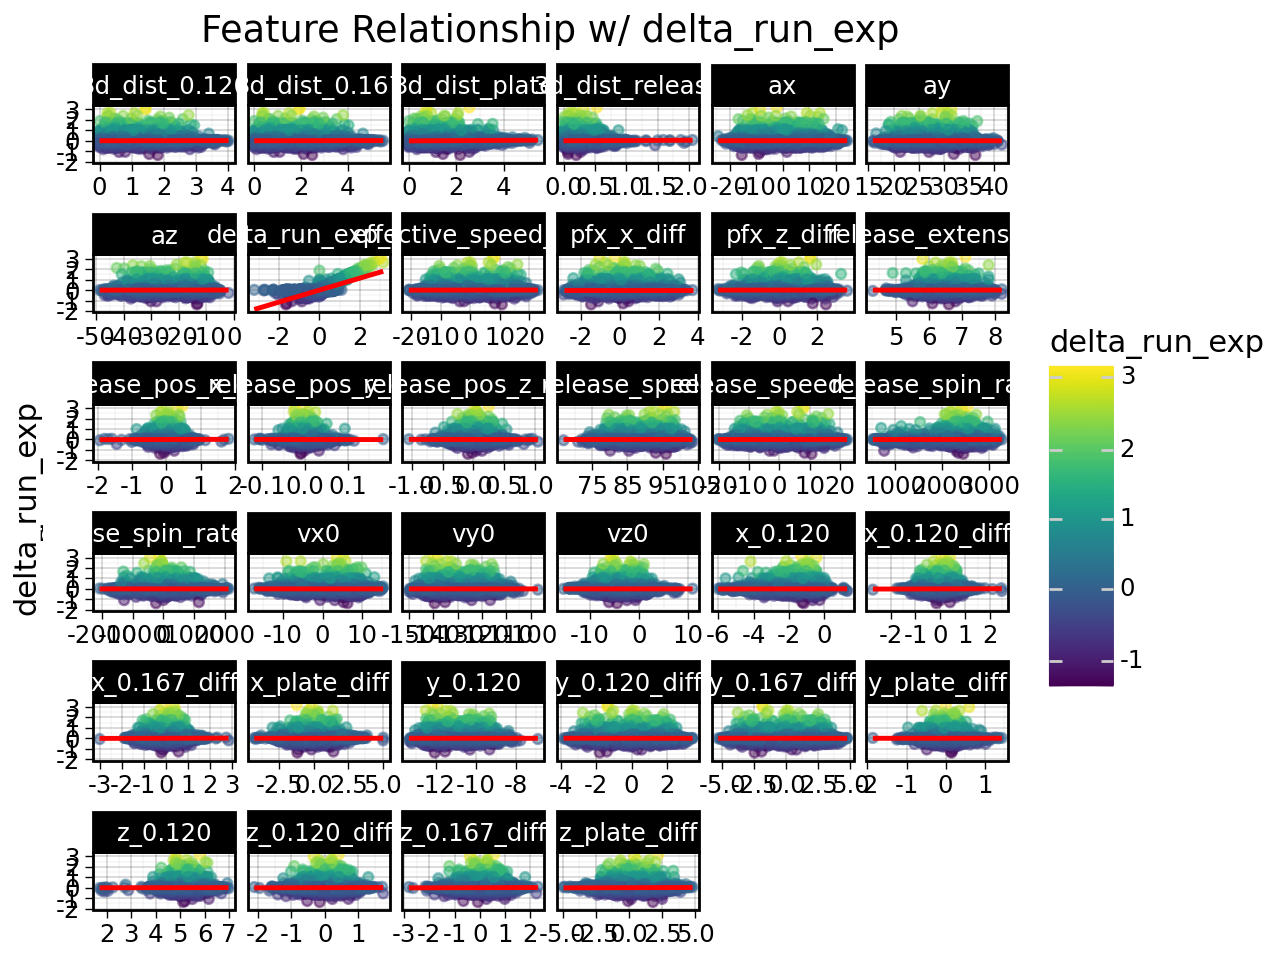

In [43]:
rel_matrix = (
    ggplot(sample_pitches_df.unpivot(index=response, on=features_of_interest),
           aes(x="value", y="delta_run_exp", color="delta_run_exp"))
    + geom_point(alpha=0.5)
    + geom_smooth(color="red")
    + facet_wrap("~ variable", scales="free_x")
    + theme_linedraw()
    + labs(
        title="Feature Relationship w/ delta_run_exp",
        y="delta_run_exp",
        x="",
    )
)

rel_matrix.show()

## Correlation Matrix

Each chunk represents the pearson correlation coefficient between two features

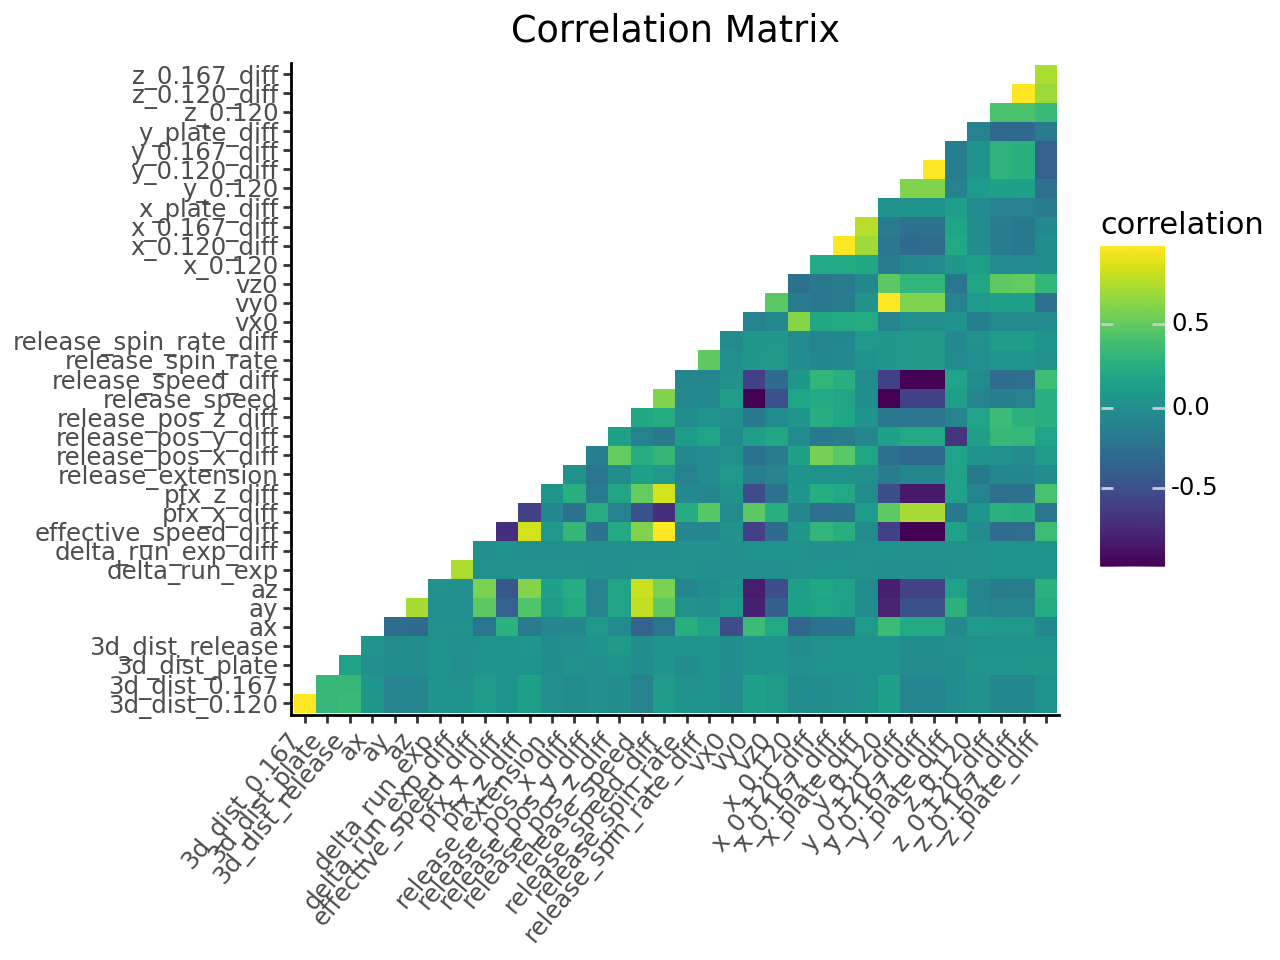

In [44]:
sample_corr_df = sample_pitches_df.corr()

corr_matrix = (
    ggplot(
        sample_corr_df
        .with_columns(pl.Series("variable_1", sample_corr_df.columns))
        .unpivot(
            index="variable_1",
            variable_name="variable_2",
            on=sample_corr_df.columns,
            value_name="correlation",
        )
        .filter(pl.col("variable_1") > pl.col("variable_2")),
        aes(x="variable_1", y="variable_2", fill="correlation"),
    )
    + geom_tile(size=3)
    + theme_classic()
    + theme(axis_text_x=element_text(rotation=50, hjust=1))
    + labs(
        title="Correlation Matrix",
        x="",
        y="",
    )
)

corr_matrix.show()

Since I am going to try to build an LSTM, which is more of a black box model, I am going to try to do [embedded feature selection](https://arxiv.org/html/2312.17517v1#:~:text=One%20common%20approach%20for%20embedded,different%20time%20steps%20or%20features.) using attention. I htink this would owrk better because the relationships between these features is complex, especially over a sequence of pitches. Embedded feature selection would allow the model to dynamically choose what features are important in any given context.

# Model Building

In [76]:
from sklearn.model_selection import train_test_split
import polars.selectors as cs
import tensorflow as tf

print(f"GPU's Available: {tf.config.list_physical_devices('GPU')}")

GPU's Available: []


In [85]:
# group each sequence of pitches together, and drop all
# columns that have at least one missing value in any of
# the features (except diff ones, b/c the first pitch in
# an AB will have null diff features). Right now I am not
# certain that I am doing this right

sequences_df = (sequence_dist_pitches_lf
                .sort("game_date", "pitcher", "at_bat_number",
                      "pitch_number", descending=[True] * 4)
                .select("game_date", "pitcher", "at_bat_number",
                        *features_of_interest, *response)
                .group_by("game_date", "pitcher", "at_bat_number")
                .agg(
                    pl.len().alias("pitches"),
                    pl.col("delta_run_exp").sum().alias("tot_delta_run_exp"),
                    *[pl.col(f) for f in features_of_interest + response],
                )
                .filter(
                    pl.all_horizontal(
                        [pl.col(f).is_not_null().all()
                        for f in features_of_interest + response
                        if not f.endswith("_diff")],
                    )
                )
                .collect())

sequences_df.head()

game_date,pitcher,at_bat_number,pitches,tot_delta_run_exp,release_spin_rate,release_speed,3d_dist_release,3d_dist_0.120,3d_dist_0.167,3d_dist_plate,ax,ay,az,x_0.120,y_0.120,z_0.120,vx0,vy0,vz0,release_extension,pfx_x_diff,pfx_z_diff,x_0.120_diff,y_0.120_diff,z_0.120_diff,x_0.167_diff,y_0.167_diff,z_0.167_diff,release_pos_x_diff,release_pos_y_diff,release_pos_z_diff,release_speed_diff,effective_speed_diff,release_spin_rate_diff,delta_run_exp_diff,x_plate_diff,y_plate_diff,z_plate_diff,delta_run_exp
datetime[μs],i64,i64,u32,f64,list[i64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[i64],list[f64],list[f64],list[f64],list[f64],list[f64]
2024-09-10 00:00:00,669212,46,5,-0.162,"[2132, 2338, … 2317]","[79.6, 86.7, … 91.3]","[0.089757, 0.105149, … 0.14589]","[1.278121, 1.041315, … 1.047404]","[1.770531, 1.357048, … 1.422378]","[1.528808, 0.797799, … 1.347102]","[-12.391836, 2.472796, … -13.08575]","[21.472732, 24.573706, … 29.185511]","[-31.739941, -32.488168, … -16.236656]","[-0.328165, -0.591993, … -0.415275]","[-9.331495, -10.541594, … -11.323459]","[5.152497, 5.468169, … 5.227362]","[2.802413, -0.607579, … 1.628781]","[-115.965457, -126.396504, … -132.900592]","[-3.066878, -0.653371, … -2.727387]","[6.6, 6.3, … 6.6]","[-1.53, 1.18, … -1.28]","[0.03, -1.51, … 1.3]","[0.263828, -0.412253, … -0.018216]","[1.210099, 0.889523, … -1.040089]","[-0.315672, 0.350902, … -0.122225]","[0.346028, -0.49708, … -0.064068]","[1.683667, 1.200282, … -1.419638]","[-0.424632, 0.392193, … -0.060683]","[-0.08, -0.06, … -0.04]","[-0.0275, 0.0325, … -0.009167]","[-0.03, 0.08, … -0.14]","[-7.1, -5.2, … 6.2]","[-6.8, -5.4, … 5.9]","[-206, 19, … -42]","[-0.115, 0.039, … -0.335]","[0.187164, -0.467912, … -0.749276]","[0.353625, -0.591647, … 0.329837]","[-1.475525, -0.259799, … 1.069803]","[-0.115, 0.0, … -0.023]"
2024-05-25 00:00:00,573186,38,6,-0.161,"[2260, 2305, … 2479]","[88.8, 88.0, … 86.6]","[0.121452, 0.496969, … 0.123426]","[0.336207, 1.376025, … 1.04641]","[0.447872, 1.822529, … 1.395424]","[0.863046, 1.663046, … 1.472263]","[-5.757493, -5.779628, … 3.293632]","[26.758221, 26.815716, … 27.679178]","[-30.113565, -29.880151, … -34.463798]","[-0.204271, -0.267741, … -0.834897]","[-10.82642, -10.6684, … -10.428581]","[4.986512, 5.276403, … 5.456267]","[5.748493, 4.466307, … 1.514051]","[-129.285108, -128.08349, … -126.080537]","[-1.395739, 0.324336, … 2.472112]","[5.6, 5.4, … 5.4]","[0.03, -2.03, … 0.81]","[-0.05, 0.63, … -0.74]","[0.06347, 0.536511, … -0.46026]","[-0.15802, -1.197517, … 0.708066]","[-0.289891, 0.414191, … 0.617882]","[0.123356, 0.531979, … -0.560031]","[-0.212516, -1.678558, … 0.978555]","[-0.374445, 0.470164, … 0.822195]","[-0.09, 0.38, … -0.12]","[-0.015833, 0.013333, … 0.020833]","[-0.08, 0.32, … 0.02]","[0.8, 6.8, … -3.9]","[1.2, 7.5, … -4.7]","[-45, -483, … 141]","[-0.169, 0.027, … -0.437]","[0.410782, -0.42307, … -0.683671]","[0.119857, -0.746749, … 0.004302]","[-0.749494, 1.424465, … 1.303892]","[-0.142, 0.027, … -0.023]"
2024-05-07 00:00:00,641729,65,3,0.146,"[2113, 2091, 2393]","[85.2, 84.2, 95.0]","[0.179382, 0.493989, null]","[0.751108, 2.007969, null]","[0.966656, 2.688369, null]","[1.763289, 0.767546, null]","[1.348057, 4.751049, -12.415541]","[24.025158, 25.263703, 31.774161]","[-27.094877, -30.119727, -11.400654]","[-1.777791, -2.263189, -1.419832]","[-10.329694, -10.15226, -11.964815]","[5.076574, 5.621614, 5.433638]","[5.797056, 2.950294, 7.180346]","[-123.972106, -122.639175, -138.087264]","[-3.429366, 0.549995, -3.915947]","[7.3, 7.2, 7.1]","[-0.29, 1.37, null]","[0.21, -1.33, null]","[0.485399, -0.843358, null]","[-0.177434, 1.812554, null]","[-0.54504, 0.187975, null]","[0.600383, -0.945634, null]","[-0.245756, 2.499192, null]","[-0.716638, 0.295198, null]","[0.16, -0.42, null]",